In [1]:
import numpy as np
import torch
from fastai.torch_core import show_image
# A gaussian kernel cache, so we don't have to regenerate them every time.
# This is only a small optimization, generating the kernels is pretty fast.
_gaussians = {}

def generate_gaussian(t, x, y, sigma=10):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.

    x should be in range (-1, 1) to match the output of fastai's PointScaler.

    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape

    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)

    tmp_size = sigma * 3

    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)

    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t

    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2

    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else torch.Tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g

    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1

    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)

    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]

    return t


In [2]:

# Example:
a = generate_gaussian(torch.zeros(256, 256), 0, 0, sigma = 2)


<Axes: >

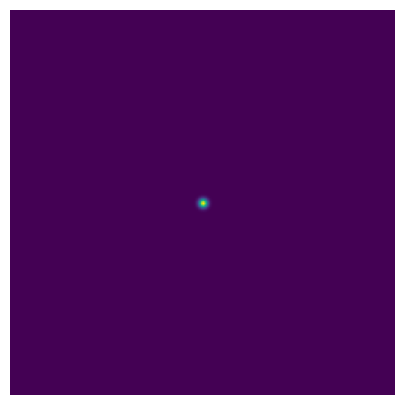

In [3]:
show_image(a)

In [4]:
from datasets import KeyPointDataset, DepthDataset
from pathlib import Path
import torchvision.transforms as T

In [5]:
keypoint_dataset = KeyPointDataset(root=Path('/home/suyash/Gatech/DDRL/modules/data/aflw_dataset/AFLW_lists/front.GTB'), mode="train")

In [6]:
first_image = keypoint_dataset.__getitem__(0)

In [7]:
first_image['image'].permute(1, 2, 0).numpy()

array([[[ 0.36518532, -0.86274505, -0.37525052],
        [ 0.34806055, -0.86274505, -0.37525052],
        [ 0.34806055, -0.86274505, -0.3403921 ],
        ...,
        [-1.7411593 , -1.7380952 , -1.4384313 ],
        [-1.7411593 , -1.7380952 , -1.4384313 ],
        [-1.7411593 , -1.7380952 , -1.4384313 ]],

       [[ 0.34806055, -0.880252  , -0.39267972],
        [ 0.34806055, -0.880252  , -0.39267972],
        [ 0.34806055, -0.880252  , -0.37525052],
        ...,
        [-1.7240345 , -1.7380952 , -1.4210021 ],
        [-1.7411593 , -1.7380952 , -1.4384313 ],
        [-1.7582841 , -1.7556021 , -1.4210021 ]],

       [[ 0.34806055, -0.91526604, -0.4275381 ],
        [ 0.34806055, -0.91526604, -0.4275381 ],
        [ 0.3309358 , -0.91526604, -0.4275381 ],
        ...,
        [-1.7240345 , -1.7380952 , -1.3861437 ],
        [-1.7582841 , -1.7556021 , -1.4035729 ],
        [-1.7754089 , -1.7556021 , -1.4210021 ]],

       ...,

       [[-0.7650484 , -1.7906162 , -1.1944226 ],
        [-0

In [8]:
T.ToPILImage()(first_image['image']).show()

In [9]:
first_image['image'].size()

torch.Size([3, 256, 256])

In [10]:
first_image['image'].size()[1]

256

In [11]:
def get_coordinate_tuples(first_image):
    coords = []
    for i in range(len(first_image['label'])):
        if i%2 == 0:
            coords.append((first_image['label'][i], first_image['label'][i+1]))
    return coords

In [12]:
get_coordinate_tuples(first_image)

[(64.07025327366735, 205.2680437858682),
 (59.00782498597312, 179.9558270714403),
 (64.56117869295963, 157.09370419978526),
 (62.28578630122107, 115.30303734594486),
 (55.03260398749006, 85.58205485875985),
 (53.032916542935055, 56.88383136667225),
 (76.29002662634238, 200.48132044535754),
 (77.29006171670517, 177.19998703237405),
 (76.1847209362409, 150.78489393167933),
 (77.93601775182857, 106.96970255068173),
 (72.16751301168252, 85.47847961035538),
 (69.33502930625748, 65.90125266215296),
 (140.83751066173633, 154.06285524692726),
 (140.77838673360455, 130.3185939248431),
 (147.38358211471035, 110.1416621424362),
 (183.77234479452693, 171.57884434735396),
 (189.22916521937142, 133.79845080986723),
 (181.46371280698065, 101.62810843240982),
 (232.13190035531568, 134.99622805542475)]

In [13]:
def get_shifted_keypoints(first_image):
    coords = get_coordinate_tuples(first_image)
    shift_amount_0 = first_image['image'].size()[1]
    shift_amount_1 = first_image['image'].size()[2]
    return [((x[0] - shift_amount_0/2)/shift_amount_0, (x[1] - shift_amount_1/2)/shift_amount_1) for x in coords]

In [14]:
shifted_keypoints = get_shifted_keypoints(first_image)

In [15]:
shifted_keypoints

[(-0.24972557314973692, 0.30182829603854766),
 (-0.2695006836485425, 0.20295244949781366),
 (-0.24780789573062645, 0.11364728203041119),
 (-0.2566961472608552, -0.0495975103674029),
 (-0.28502889067386694, -0.16569509820796935),
 (-0.29284016975415994, -0.27779753372393656),
 (-0.20199208349085007, 0.2831301579896779),
 (-0.19808569641912044, 0.19218744934521115),
 (-0.202403433842809, 0.0890034919206224),
 (-0.19556243065691964, -0.08214959941139949),
 (-0.21809565229811517, -0.1660996890220493),
 (-0.2291600417724317, -0.24257323178846502),
 (0.050146526022407545, 0.1018080283083096),
 (0.04991557317814277, 0.009057007518918359),
 (0.0757171176355873, -0.06975913225610858),
 (0.21786072185362082, 0.17022986073185142),
 (0.23917642663816963, 0.02265019847604388),
 (0.20884262815226817, -0.10301520143589915),
 (0.40676523576295187, 0.027329015841502935)]

In [16]:
cum = None
for keypoint in shifted_keypoints:
    a = generate_gaussian(torch.zeros(256, 256), keypoint[0], keypoint[1], sigma = 2)
    if cum is None:
        cum = a 
    else:
        cum = cum + a

In [17]:
a

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<Axes: >

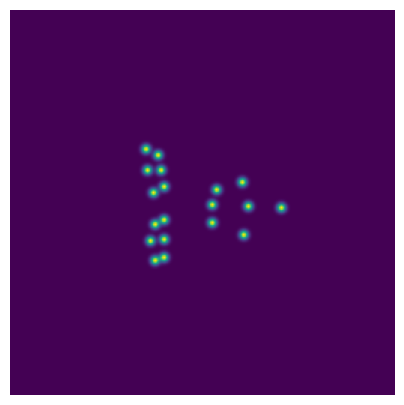

In [18]:
show_image(cum)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

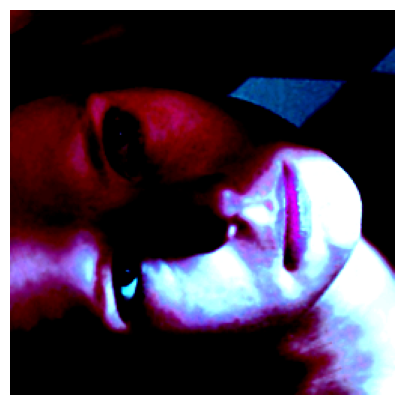

In [19]:
show_image(first_image['image'])

In [ ]:
coords = []
for i in range(len(first_image['label'])):
    if i%2 == 0:
        coords.append((first_image['label'][i], first_image['label'][i+1]))

In [ ]:
len(coords)

In [ ]:
keypoints = [cv2.KeyPoint(float(x), float(y), size=20) for (x, y) in coords]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
first_image['image'].numpy()

In [ ]:
output_image = cv2.drawKeypoints(first_image['image'].permute(1, 2, 0).numpy(), keypoints, 0, (255, 0, 0), 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
# displaying the image with keypoints as the 
# output on the screen 
plt.imshow(output_image) 
  
# plotting image 
plt.show() 